In [1]:
from jax_md import *
import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt

# jax.config.update("jax_enable_x64", True)

In [2]:
dim = 2
N = 256
box_size = quantity.box_size_at_number_density(N, 1, dim)

In [3]:
displacement, shift = space.periodic(box_size)
metric = space.metric(displacement)
v_displacement = space.map_product(displacement)
v_metric = space.map_product(metric)

My way of doing a brownian simulation, and saving the state at every timestep

In [4]:
def brownian_simulation(key, temperature, dt, steps, energy_fn):
    pos_key, sim_key, times_key = jr.split(key, 3)
    R = jr.uniform(pos_key, (N, 2), maxval=box_size)
    #R = jnp.zeros((N, 2))

    init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt, temperature)
    initial_state = init_fn(sim_key, R)
    state = init_fn(sim_key, R)

    do_step = lambda state, t: (apply_fn(state), apply_fn(state))
    final_state, intermediate_states = jax.lax.scan(do_step, state, steps)

    return initial_state.position, final_state.position, intermediate_states.position, times_key

In [7]:
initial, final, intermediate, times_key = brownian_simulation(jr.PRNGKey(0), 0.05, 0.01, jnp.arange(1000), lambda r: 0.)

In [8]:
final = jnp.expand_dims(final, 0)
initial = jnp.expand_dims(initial, 0)
all_states = jnp.concatenate((initial, intermediate, final), axis=0)
print(jnp.shape(all_states))

(1002, 256, 2)


In [9]:
jnp.save("brownian", all_states)

In [10]:
def pairwise_distances_2D_torus(coords, L):
    def distance_fn(p1, p2):
        delta = jnp.abs(p1 - p2)
        delta = jnp.minimum(delta, L - delta)
        return jnp.sqrt(jnp.sum(delta**2))

    distance_matrix = jax.vmap(
        lambda p1: jax.vmap(lambda p2: distance_fn(p1, p2))(coords)
    )(coords)
    
    return distance_matrix

In [11]:
dists = pairwise_distances_2D_torus(all_states[-1, :, :], box_size)

In [12]:
import numpy as np
dr = box_size/100
rr = jnp.arange(0, box_size, dr)
g = np.zeros_like(rr)
for k in range(N):
    for j in range(k+1, N):
        r = dists[k][j]
        bn = jnp.floor(r/dr)
        g[int(bn)] += 2

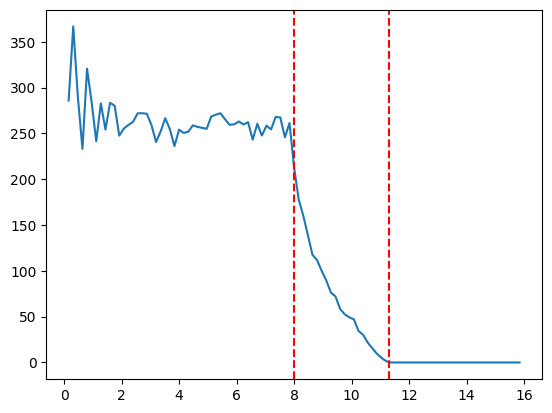

In [15]:
plt.plot(rr, g/(2*jnp.pi*rr*dr))
plt.axvline(box_size/2, linestyle="--", color="red")
plt.axvline(box_size/jnp.sqrt(2), linestyle="--", color="red")
plt.show()

In [16]:
def brownian_simulation_vec(key, temperature, dt, steps, energy_fn):
    pos_key, sim_key, times_key = jr.split(key, 3)
    R = jr.uniform(pos_key, (N, 2), maxval=box_size)
    #R = jnp.zeros((N, 2))

    init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt, temperature)
    initial_state = init_fn(sim_key, R)
    state = init_fn(sim_key, R)

    do_step = lambda state, t: (apply_fn(state), apply_fn(state))
    final_state, intermediate_states = jax.lax.scan(do_step, state, steps)

    initial = initial_state.position
    intermediate = intermediate_states.position
    final = final_state.position

    final = jnp.expand_dims(final, 0)
    initial = jnp.expand_dims(initial, 0)

    all_states = jnp.concatenate((initial, intermediate, final), axis=0)

    return all_states, times_key

brownian_simulation_vec = jax.vmap(brownian_simulation_vec, in_axes=(0, None, None, None, None))

In [17]:
keys = jr.split(jr.PRNGKey(0), 1000)

In [25]:
states, time_keys = brownian_simulation_vec(keys,  0.05, 0.01, jnp.arange(1000), lambda r: 0.)

In [26]:
print(jnp.shape(states))

(1000, 1002, 256, 2)


In [27]:
pairwise_distances_2D_torus_vec = jax.vmap(pairwise_distances_2D_torus, in_axes=(0, None))

In [46]:
def compute_g_quick(dists, length):
    # set zeros to length+1 so bincount ignores 
    dists = jnp.where(jnp.abs(dists)<1e-8, length+1, dists)
    bins = jnp.floor(dists/dr).astype(int)
    return jnp.bincount(bins.flatten(), length=length)
compute_g_quick_vec = jax.vmap(compute_g_quick, in_axes=(0, None))

In [51]:
random_times = jr.randint(jr.PRNGKey(0), (5,), minval=0, maxval=1002)

In [52]:
dr = box_size/1000
rr = jnp.arange(dr, box_size+dr, dr)

In [53]:
normalisation = jnp.roll(2*jnp.pi*rr*dr, 1)
normalisation = normalisation.at[0].set(jnp.pi*dr*dr)

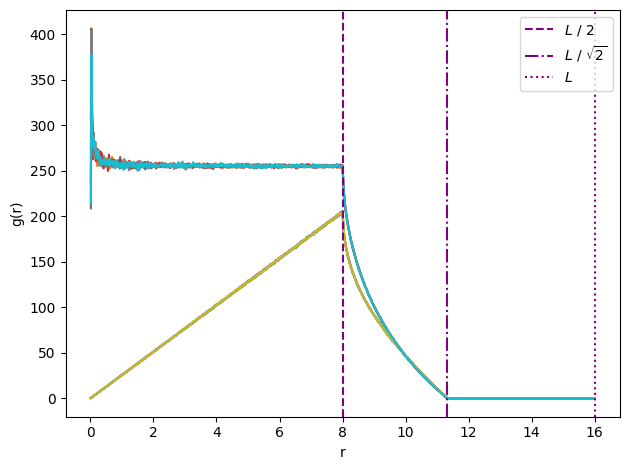

In [54]:
fig, ax = plt.subplots()
for t in random_times:
    dists = pairwise_distances_2D_torus_vec(states[:, t, :, :], box_size)
    rdfs = compute_g_quick_vec(dists, 1000)
    rdf_avg = jnp.mean(rdfs, axis=0)
    ax.plot(rr, rdf_avg)
    ax.plot(rr, rdf_avg/normalisation)
ax.axvline(box_size/2, linestyle="--", color="purple", label=r"$L~/~2$")
ax.axvline(box_size/jnp.sqrt(2), linestyle="-.", color="purple", label=r"$L~/~\sqrt{2}$")
ax.axvline(box_size, linestyle=":", color="purple", label=r"$L$")
ax.set_xlabel("r")
ax.set_ylabel("g(r)")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
dists = pairwise_distances_2D_torus_vec(states[:, -1, :, :], box_size)

In [16]:
print(jnp.shape(dists))

(1000, 256, 256)


In [17]:
dr = box_size/1000
rr = jnp.arange(dr, box_size+dr, dr)
print(jnp.shape(rr))

(1000,)


In [18]:
dr = box_size/1000
rr = jnp.arange(dr, box_size+dr, dr)
@jax.vmap
def compute_g(dists):
    g = jnp.zeros_like(rr)
    for k in range(N):
        for j in range(k+1, N):
            r = dists[k][j]
            bn = jnp.floor(r/dr)
            tmp = g[bn.astype(int)]
            g = g.at[bn.astype(int)].set(tmp+2)
    return g

In [19]:
def compute_g_quick(dists, length):
    # set zeros to length+1 so bincount ignores 
    dists = jnp.where(jnp.abs(dists)<1e-8, length+1, dists)
    bins = jnp.floor(dists/dr).astype(int)
    return jnp.bincount(bins.flatten(), length=length)
compute_g_quick_vec = jax.vmap(compute_g_quick, in_axes=(0, None))

In [20]:
rdfs_quick = compute_g_quick_vec(dists, 1000)

In [187]:
print(jnp.shape(rdfs_quick))

(1000, 1000)


In [168]:
rdfs = compute_g(dists)

In [178]:
print(jnp.shape(rdfs))

(1000, 1000)


In [188]:
jnp.allclose(rdfs, rdfs_quick)

Array(True, dtype=bool)

In [21]:
#rdf_avg = jnp.mean(rdfs, axis=0)
rdf_quick_avg = jnp.mean(rdfs_quick, axis=0)
#print(jnp.allclose(rdf_avg, rdf_quick_avg))

In [192]:
print(jnp.shape(rdf_avg))

(1000,)


In [22]:
normalisation = jnp.roll(2*jnp.pi*rr*dr, 1)
normalisation = normalisation.at[0].set(jnp.pi*dr*dr)

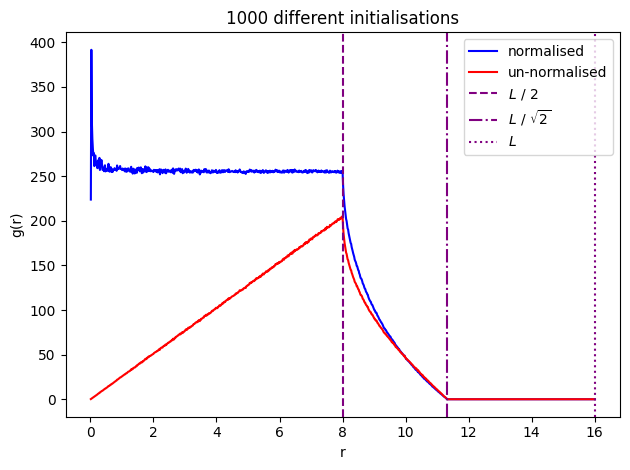

In [23]:
#plt.plot(rr, rdf_avg/(2*jnp.pi*rr*dr))
#plt.plot(rr, rdf_avg/(normalisation), color="blue", label="normalised")
#plt.plot(rr, rdf_avg, color="red", label="un-normalised")
plt.plot(rr, rdf_quick_avg/(normalisation), color="blue", label="normalised")
plt.plot(rr, rdf_quick_avg, color="red", label="un-normalised")
plt.axvline(box_size/2, linestyle="--", color="purple", label=r"$L~/~2$")
plt.axvline(box_size/jnp.sqrt(2), linestyle="-.", color="purple", label=r"$L~/~\sqrt{2}$")
plt.axvline(box_size, linestyle=":", color="purple", label=r"$L$")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("1000 different initialisations")
plt.legend()
plt.tight_layout()
#plt.savefig("2d_bm_torus_initial_uniform_rdf.png", dpi=300)
plt.show()

In [33]:
ells = jnp.linspace(box_size/2, box_size/jnp.sqrt(2), 100)
def area_ratio(ells):
    return 4*box_size*box_size/(jnp.pi*ells*ells) - 1
ratios = area_ratio(ells)

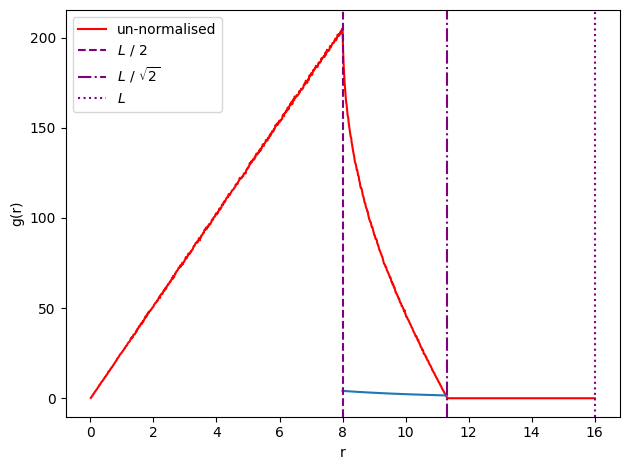

In [36]:
plt.plot(rr, rdf_quick_avg, color="red", label="un-normalised")
plt.plot(ells, ratios)
plt.axvline(box_size/2, linestyle="--", color="purple", label=r"$L~/~2$")
plt.axvline(box_size/jnp.sqrt(2), linestyle="-.", color="purple", label=r"$L~/~\sqrt{2}$")
plt.axvline(box_size, linestyle=":", color="purple", label=r"$L$")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.legend()
plt.tight_layout()
#plt.savefig("2d_bm_torus_initial_uniform_rdf.png", dpi=300)
plt.show()